# 02 — Clean & EDA
Input: `data/combined_team_stats.csv`  
Output: `data/clean_team_stats.csv` and `images/top_corr_with_winpct.png`


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

# find repo folders (works whether notebook runs at root or /notebooks)
ROOT = Path(".").resolve()
DATA = Path("data") if Path("data").exists() else Path("../data")
IMAGES = Path("images") if Path("images").exists() else Path("../images")
IMAGES.mkdir(exist_ok=True)

print("DATA:", DATA.resolve())
df = pd.read_csv(DATA / "combined_team_stats.csv")
df.head(), df.shape


DATA: C:\Users\jeff\Documents\nba-win-predictor\data


(                 team  season  wins  losses  pace   ortg   drtg  net_rating  \
 0      Atlanta Hawks*    2014  38.0    44.0  94.6  105.9  106.4        -0.5   
 1      Boston Celtics    2014  25.0    57.0  93.3  102.9  107.7        -4.8   
 2      Brooklyn Nets*    2014  44.0    38.0  91.4  106.7  107.7        -1.0   
 3  Charlotte Bobcats*    2014  43.0    39.0  92.4  103.6  103.8        -0.2   
 4      Chicago Bulls*    2014  48.0    34.0  90.2  102.5  100.5         2.0   
 
     srs  threepar    ftr  ft_fga  
 0 -0.88     0.316  0.266   0.208  
 1 -4.97     0.251  0.248   0.193  
 2 -1.58     0.301  0.313   0.236  
 3 -0.89     0.219  0.297   0.219  
 4  1.20     0.222  0.290   0.226  ,
 (360, 12))

In [2]:
# create target
df["games"] = df["wins"] + df["losses"]
df = df[df["games"] > 0]
df["win_pct"] = df["wins"] / df["games"]

# coerce numerics (leave team/season as id)
id_cols = ["team","season"]
for c in df.columns:
    if c not in id_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df[["team","season","wins","losses","win_pct"]].head()


,team,season,wins,losses,win_pct
0,Atlanta Hawks*,2014,38.0,44.0,0.463415
1,Boston Celtics,2014,25.0,57.0,0.304878
2,Brooklyn Nets*,2014,44.0,38.0,0.536585
3,Charlotte Bobcats*,2014,43.0,39.0,0.524390
4,Chicago Bulls*,2014,48.0,34.0,0.585366


In [4]:
# if net_rating is missing but ortg/drtg exist, build it
if "net_rating" not in df.columns and {"ortg","drtg"}.issubset(df.columns):
    df["net_rating"] = df["ortg"] - df["drtg"]

# convenience ratios if present
if {"ftr","threepar"}.issubset(df.columns):
    df["spacing_index"] = df["threepar"] - df["ftr"]  # crude proxy: more 3s vs FT rate


In [5]:
num_cols = [c for c in df.columns if c not in ["team","season"]]
missing_pct = df[num_cols].isna().mean()

# drop columns with > 40% missing
drop_cols = missing_pct[missing_pct > 0.40].index.tolist()
df = df.drop(columns=drop_cols)

# fill remaining with column median
for c in [c for c in df.columns if c not in ["team","season"]]:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

df.shape, drop_cols

((360, 15), [])

In [6]:
rate_like = [c for c in df.columns if c.endswith("pct") or "rating" in c or c in ["pace","win_pct","spacing_index"]]
for c in rate_like:
    if c in df.columns:
        q1, q99 = df[c].quantile([0.001, 0.999])
        df = df[df[c].between(q1, q99)]
df.shape

(353, 15)

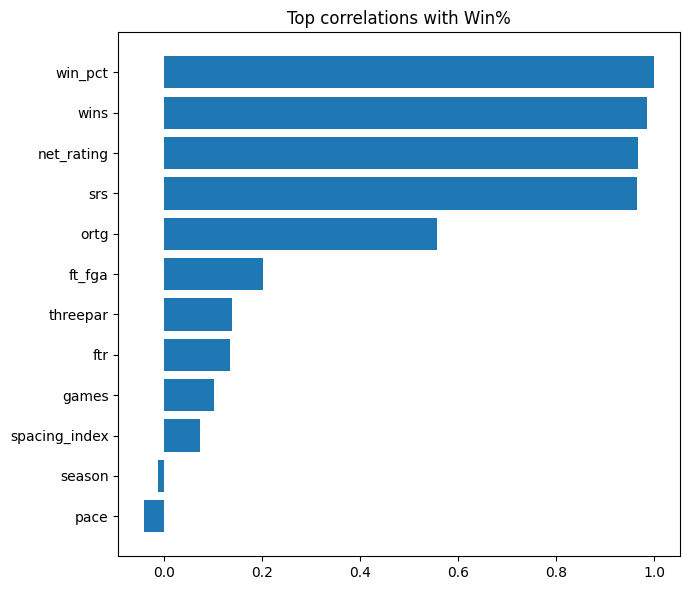

(WindowsPath('images/top_corr_with_winpct.png'),
 win_pct          1.000000
 wins             0.985549
 net_rating       0.966346
 srs              0.964171
 ortg             0.555913
 ft_fga           0.203082
 threepar         0.138316
 ftr              0.134750
 games            0.103330
 spacing_index    0.073520
 season          -0.010947
 pace            -0.040025
 Name: win_pct, dtype: float64)

In [7]:
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)["win_pct"].sort_values(ascending=False)
top = corr.head(12)

plt.figure(figsize=(7,6))
plt.barh(list(reversed(top.index)), list(reversed(top.values)))
plt.title("Top correlations with Win%")
plt.tight_layout()
out_img = IMAGES / "top_corr_with_winpct.png"
plt.savefig(out_img, dpi=200)
plt.show()

out_img, top


In [8]:
out_csv = DATA / "clean_team_stats.csv"
df.to_csv(out_csv, index=False)
out_csv


WindowsPath('data/clean_team_stats.csv')